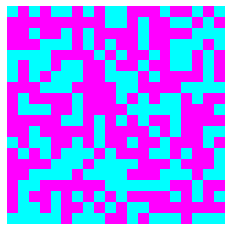

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
N = 20
prob = 0.5
I_1d = np.random.choice(a=[False, True], size=(1,N), p=[prob, 1-prob])  

I_2d = np.random.choice(a=[False, True], size=(N, N), p=[prob, 1-prob])  

plt.axis('off')
plt.imshow(I_1d, cmap='cool',interpolation='nearest')
plt.show()
plt.axis('off')
plt.imshow(I_2d, cmap='cool',interpolation='nearest')
plt.show()